# Import libraries

In [1]:
import tensorflow as tf

In [2]:
import tensorflow as tf 
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt
from tensorflow import keras 


# Set base directory of project

In [4]:
ROOT_DIR = "C:/mask_rcnn/Mask_RCNN-master/Mask_RCNN-master"

import mask rccn model dependencies

In [5]:
# import mask rcnn
print(sys.path.append(ROOT_DIR))
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize

None


Using TensorFlow backend.


set weight and log directory path

In [6]:
# weight file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, 'mask_rccn_coco.h5')

# logs directory
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, 'logs')

# Configer the device

In [7]:

# define function to config your device 

class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    
    NAME = "object"

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 1  

    STEPS_PER_EPOCH = 2

    DETECTION_MIN_CONFIDENCE = 0.9

check is configration is done or not

In [8]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "/dataset/")
class InferenceConfig(config.__class__):
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 3 
    DETECTION_MIN_CONFIDENCE = 0.7
    

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# set anotation file and class id and label

In [9]:
# Code for Customdataset class. Same code is present in custom.py file also
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        self.add_class("object", 1, "sidewalk")
        
        assert subset in ["train", "valid"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations1 = json.load(open(os.path.join(dataset_dir, 'sidewalk_json.json')))
        
        annotations = list(annotations1.values())  # don't need the dict keys

        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
           
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"sidewalk": 1}
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object", 
                image_id=a['filename'],  
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
       
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

# set training pipeline

In [10]:
def train(model):
    """Train the model."""
    
    dataset_train = CustomDataset()
    dataset_train.load_custom("C:/mask_rcnn/Mask_RCNN-master/Mask_RCNN-master/dataset", "train")
    
    dataset_train.prepare()

    
    dataset_val = CustomDataset()
    dataset_val.load_custom("C:/mask_rcnn/Mask_RCNN-master/Mask_RCNN-master/dataset", "valid")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=300,
                layers='heads')

# set  model for training 

In [11]:
from mrcnn.config import Config

config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH
        # Download weights file
if not os.path.exists(weights_path):
    utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








# Run the code

In [12]:
#from keras.callbacks import TensorBoard
train(model)


objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: ['sidewalk']
numids [1]
objects: [

C:\Users\nodru\anaconda3\envs\dp\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\nodru\anaconda3\envs\dp\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\nodru\anaconda3\envs\dp\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/300
2/2 [==============================] - 47s 23s/step - loss: 5.7000 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.3058 - mrcnn_class_loss: 1.2930 - mrcnn_bbox_loss: 1.3097 - mrcnn_mask_loss: 2.7511 - val_loss: 5.0869 - val_rpn_class_loss: 0.1730 - val_rpn_bbox_loss: 0.5391 - val_mrcnn_class_loss: 0.2536 - val_mrcnn_bbox_loss: 1.1901 - val_mrcnn_mask_loss: 2.9310

Epoch 2/300
2/2 [==============================] - 25s 13s/step - loss: 4.9425 - rpn_class_loss: 0.1937 - rpn_bbox_loss: 0.9640 - mrcnn_class_loss: 0.2293 - mrcnn_bbox_loss: 1.1724 - mrcnn_mask_loss: 2.3832 - val_loss: 4.0657 - val_rpn_class_loss: 0.1759 - val_rpn_bbox_loss: 0.5390 - val_mrcnn_class_loss: 0.1207 - val_mrcnn_bbox_loss: 0.8947 - val_mrcnn_mask_loss: 2.3353
Epoch 3/300
2/2 [==============================] - 25s 12s/step - loss: 4.0353 - rpn_class_loss: 0.1219 - rpn_bbox_loss: 0.4880 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.9106 - mrcnn_mask_loss: 2.4323 - val_loss: 3.1760 - val_rpn_class_loss:

Epoch 42/300
2/2 [==============================] - 21s 10s/step - loss: 2.2219 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.0059 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.4401 - mrcnn_mask_loss: 0.6141 - val_loss: 1.0984 - val_rpn_class_loss: 0.0076 - val_rpn_bbox_loss: 0.2914 - val_mrcnn_class_loss: 0.0230 - val_mrcnn_bbox_loss: 0.3160 - val_mrcnn_mask_loss: 0.4604
Epoch 43/300
2/2 [==============================] - 21s 10s/step - loss: 1.4750 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.6606 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.2742 - mrcnn_mask_loss: 0.5052 - val_loss: 1.1591 - val_rpn_class_loss: 0.0069 - val_rpn_bbox_loss: 0.2962 - val_mrcnn_class_loss: 0.0296 - val_mrcnn_bbox_loss: 0.3609 - val_mrcnn_mask_loss: 0.4655
Epoch 44/300
2/2 [==============================] - 21s 10s/step - loss: 1.3913 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.4514 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.3560 - mrcnn_mask_loss: 0.5412 - val_loss: 1.1347 - val_rpn_class_loss: 0

Epoch 64/300
2/2 [==============================] - 21s 11s/step - loss: 0.9623 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.3896 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.3191 - val_loss: 0.6294 - val_rpn_class_loss: 0.0060 - val_rpn_bbox_loss: 0.2172 - val_mrcnn_class_loss: 0.0229 - val_mrcnn_bbox_loss: 0.1282 - val_mrcnn_mask_loss: 0.2550
Epoch 65/300
2/2 [==============================] - 20s 10s/step - loss: 0.9230 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.2668 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.3505 - mrcnn_mask_loss: 0.2766 - val_loss: 0.6279 - val_rpn_class_loss: 0.0064 - val_rpn_bbox_loss: 0.2231 - val_mrcnn_class_loss: 0.0249 - val_mrcnn_bbox_loss: 0.1221 - val_mrcnn_mask_loss: 0.2514
Epoch 66/300
2/2 [==============================] - 20s 10s/step - loss: 0.5776 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.2143 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.1658 - mrcnn_mask_loss: 0.1641 - val_loss: 0.6215 - val_rpn_class_loss: 0

Epoch 86/300
2/2 [==============================] - 20s 10s/step - loss: 0.4477 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1717 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0903 - mrcnn_mask_loss: 0.1658 - val_loss: 0.6022 - val_rpn_class_loss: 0.0051 - val_rpn_bbox_loss: 0.1884 - val_mrcnn_class_loss: 0.0223 - val_mrcnn_bbox_loss: 0.1770 - val_mrcnn_mask_loss: 0.2094
Epoch 87/300
2/2 [==============================] - 20s 10s/step - loss: 0.5540 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2754 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.1236 - val_loss: 0.5695 - val_rpn_class_loss: 0.0049 - val_rpn_bbox_loss: 0.1894 - val_mrcnn_class_loss: 0.0201 - val_mrcnn_bbox_loss: 0.1412 - val_mrcnn_mask_loss: 0.2139
Epoch 88/300
2/2 [==============================] - 20s 10s/step - loss: 0.4696 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.2266 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0961 - mrcnn_mask_loss: 0.1313 - val_loss: 0.5283 - val_rpn_class_loss: 0

Epoch 108/300
2/2 [==============================] - 20s 10s/step - loss: 0.3230 - rpn_class_loss: 6.4085e-04 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0978 - mrcnn_mask_loss: 0.1046 - val_loss: 0.5367 - val_rpn_class_loss: 0.0058 - val_rpn_bbox_loss: 0.2272 - val_mrcnn_class_loss: 0.0197 - val_mrcnn_bbox_loss: 0.1190 - val_mrcnn_mask_loss: 0.1650
Epoch 109/300
2/2 [==============================] - 20s 10s/step - loss: 0.4820 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2165 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1605 - val_loss: 0.5710 - val_rpn_class_loss: 0.0057 - val_rpn_bbox_loss: 0.2289 - val_mrcnn_class_loss: 0.0164 - val_mrcnn_bbox_loss: 0.1630 - val_mrcnn_mask_loss: 0.1570
Epoch 110/300
2/2 [==============================] - 20s 10s/step - loss: 0.3899 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1769 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1143 - val_loss: 0.4936 - val_rpn_class_

Epoch 130/300
2/2 [==============================] - 20s 10s/step - loss: 0.7128 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3229 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.1485 - val_loss: 0.4647 - val_rpn_class_loss: 0.0053 - val_rpn_bbox_loss: 0.1931 - val_mrcnn_class_loss: 0.0205 - val_mrcnn_bbox_loss: 0.1114 - val_mrcnn_mask_loss: 0.1344
Epoch 131/300
2/2 [==============================] - 20s 10s/step - loss: 0.5949 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.3750 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.1350 - mrcnn_mask_loss: 0.0788 - val_loss: 0.4839 - val_rpn_class_loss: 0.0065 - val_rpn_bbox_loss: 0.2033 - val_mrcnn_class_loss: 0.0190 - val_mrcnn_bbox_loss: 0.1160 - val_mrcnn_mask_loss: 0.1392
Epoch 132/300
2/2 [==============================] - 20s 10s/step - loss: 0.7719 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.3326 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.2832 - mrcnn_mask_loss: 0.1359 - val_loss: 0.4974 - val_rpn_class_loss

Epoch 152/300
2/2 [==============================] - 20s 10s/step - loss: 0.9295 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.4260 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.2948 - mrcnn_mask_loss: 0.1477 - val_loss: 0.4048 - val_rpn_class_loss: 0.0047 - val_rpn_bbox_loss: 0.1777 - val_mrcnn_class_loss: 0.0164 - val_mrcnn_bbox_loss: 0.0717 - val_mrcnn_mask_loss: 0.1343
Epoch 153/300
2/2 [==============================] - 20s 10s/step - loss: 0.9401 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.5424 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.2628 - mrcnn_mask_loss: 0.1064 - val_loss: 0.4201 - val_rpn_class_loss: 0.0055 - val_rpn_bbox_loss: 0.1844 - val_mrcnn_class_loss: 0.0154 - val_mrcnn_bbox_loss: 0.0744 - val_mrcnn_mask_loss: 0.1404
Epoch 154/300
2/2 [==============================] - 20s 10s/step - loss: 0.5719 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.2275 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0762 - mrcnn_mask_loss: 0.2499 - val_loss: 0.4030 - val_rpn_class_loss

Epoch 174/300
2/2 [==============================] - 20s 10s/step - loss: 1.0556 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.6064 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.3238 - mrcnn_mask_loss: 0.0993 - val_loss: 0.4406 - val_rpn_class_loss: 0.0068 - val_rpn_bbox_loss: 0.1839 - val_mrcnn_class_loss: 0.0156 - val_mrcnn_bbox_loss: 0.1141 - val_mrcnn_mask_loss: 0.1203
Epoch 175/300
2/2 [==============================] - 20s 10s/step - loss: 1.1329 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.6994 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.1188 - val_loss: 0.4555 - val_rpn_class_loss: 0.0045 - val_rpn_bbox_loss: 0.1919 - val_mrcnn_class_loss: 0.0110 - val_mrcnn_bbox_loss: 0.1253 - val_mrcnn_mask_loss: 0.1229
Epoch 176/300
2/2 [==============================] - 20s 10s/step - loss: 0.3594 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.1165 - mrcnn_mask_loss: 0.1172 - val_loss: 0.4369 - val_rpn_class_loss

Epoch 196/300
2/2 [==============================] - 20s 10s/step - loss: 0.3630 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1346 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.0813 - val_loss: 0.4106 - val_rpn_class_loss: 0.0063 - val_rpn_bbox_loss: 0.1926 - val_mrcnn_class_loss: 0.0122 - val_mrcnn_bbox_loss: 0.0894 - val_mrcnn_mask_loss: 0.1100
Epoch 197/300
2/2 [==============================] - 20s 10s/step - loss: 0.3886 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2124 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.0772 - val_loss: 0.3668 - val_rpn_class_loss: 0.0050 - val_rpn_bbox_loss: 0.1586 - val_mrcnn_class_loss: 0.0153 - val_mrcnn_bbox_loss: 0.0813 - val_mrcnn_mask_loss: 0.1065
Epoch 198/300
2/2 [==============================] - 20s 10s/step - loss: 0.4657 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2468 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1434 - val_loss: 0.3759 - val_rpn_class_loss

Epoch 218/300
2/2 [==============================] - 20s 10s/step - loss: 0.3842 - rpn_class_loss: 4.9683e-04 - rpn_bbox_loss: 0.1911 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.0892 - val_loss: 0.3696 - val_rpn_class_loss: 0.0045 - val_rpn_bbox_loss: 0.1781 - val_mrcnn_class_loss: 0.0125 - val_mrcnn_bbox_loss: 0.0710 - val_mrcnn_mask_loss: 0.1036
Epoch 219/300
2/2 [==============================] - 20s 10s/step - loss: 0.3353 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1452 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.0894 - val_loss: 0.3727 - val_rpn_class_loss: 0.0034 - val_rpn_bbox_loss: 0.1593 - val_mrcnn_class_loss: 0.0137 - val_mrcnn_bbox_loss: 0.0886 - val_mrcnn_mask_loss: 0.1077
Epoch 220/300
2/2 [==============================] - 20s 10s/step - loss: 0.3565 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.1034 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.1134 - val_loss: 0.3627 - val_rpn_class_

Epoch 240/300
2/2 [==============================] - 20s 10s/step - loss: 0.5757 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.2991 - mrcnn_mask_loss: 0.1075 - val_loss: 0.3896 - val_rpn_class_loss: 0.0049 - val_rpn_bbox_loss: 0.1910 - val_mrcnn_class_loss: 0.0146 - val_mrcnn_bbox_loss: 0.0832 - val_mrcnn_mask_loss: 0.0958
Epoch 241/300
2/2 [==============================] - 20s 10s/step - loss: 0.4934 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.2856 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.0778 - val_loss: 0.3895 - val_rpn_class_loss: 0.0047 - val_rpn_bbox_loss: 0.1877 - val_mrcnn_class_loss: 0.0149 - val_mrcnn_bbox_loss: 0.0859 - val_mrcnn_mask_loss: 0.0963
Epoch 242/300
2/2 [==============================] - 20s 10s/step - loss: 0.2355 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1147 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0556 - val_loss: 0.3616 - val_rpn_class_loss

Epoch 262/300
2/2 [==============================] - 20s 10s/step - loss: 0.6125 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.3311 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.1487 - mrcnn_mask_loss: 0.0927 - val_loss: 0.3965 - val_rpn_class_loss: 0.0055 - val_rpn_bbox_loss: 0.2213 - val_mrcnn_class_loss: 0.0139 - val_mrcnn_bbox_loss: 0.0682 - val_mrcnn_mask_loss: 0.0875
Epoch 263/300
2/2 [==============================] - 20s 10s/step - loss: 0.6932 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4610 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1599 - mrcnn_mask_loss: 0.0475 - val_loss: 0.4061 - val_rpn_class_loss: 0.0034 - val_rpn_bbox_loss: 0.2316 - val_mrcnn_class_loss: 0.0140 - val_mrcnn_bbox_loss: 0.0681 - val_mrcnn_mask_loss: 0.0889
Epoch 264/300
2/2 [==============================] - 20s 10s/step - loss: 0.8606 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.5491 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.1895 - mrcnn_mask_loss: 0.0854 - val_loss: 0.3925 - val_rpn_class_loss

Epoch 284/300
2/2 [==============================] - 20s 10s/step - loss: 1.1326 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.4515 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.5515 - mrcnn_mask_loss: 0.0726 - val_loss: 0.3654 - val_rpn_class_loss: 0.0058 - val_rpn_bbox_loss: 0.2008 - val_mrcnn_class_loss: 0.0109 - val_mrcnn_bbox_loss: 0.0653 - val_mrcnn_mask_loss: 0.0826
Epoch 285/300
2/2 [==============================] - 20s 10s/step - loss: 0.3095 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.0925 - val_loss: 0.3445 - val_rpn_class_loss: 0.0047 - val_rpn_bbox_loss: 0.1816 - val_mrcnn_class_loss: 0.0116 - val_mrcnn_bbox_loss: 0.0636 - val_mrcnn_mask_loss: 0.0831
Epoch 286/300
2/2 [==============================] - 20s 10s/step - loss: 0.2425 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0374 - mrcnn_mask_loss: 0.0721 - val_loss: 0.3498 - val_rpn_class_loss

In [14]:
import pandas as pd
epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history,index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,5.086861,0.172990,0.539134,0.253598,1.190136,2.931002,5.699971,0.040480,0.305754,1.293012,1.309654,2.751070
2,4.065654,0.175878,0.538994,0.120734,0.894715,2.335332,4.942525,0.193686,0.963965,0.229299,1.172383,2.383191
3,3.175982,0.168079,0.530164,0.122608,0.755237,1.599893,4.035330,0.121883,0.487957,0.082586,0.910642,2.432260
4,2.909520,0.165017,0.507763,0.102870,0.935159,1.198709,3.711193,0.050382,1.488972,0.058298,0.880892,1.232647
5,2.737204,0.158590,0.487847,0.069024,0.911055,1.110687,2.410802,0.072402,0.377964,0.105000,0.870034,0.985400
...,...,...,...,...,...,...,...,...,...,...,...,...
296,0.344585,0.003404,0.176536,0.012142,0.062626,0.089875,0.362405,0.001119,0.206250,0.022645,0.071341,0.061049
297,0.339442,0.003945,0.181336,0.012004,0.054973,0.087182,0.376651,0.007948,0.192357,0.009084,0.093080,0.074181
298,0.337166,0.005680,0.169991,0.012416,0.063620,0.085458,0.269207,0.006535,0.152538,0.009840,0.034058,0.066234
299,0.333994,0.004829,0.167928,0.012881,0.060440,0.087915,0.281317,0.003375,0.141843,0.017277,0.048894,0.069927


In [16]:
os.getcwd()

'C:\\mask_rcnn\\Mask_RCNN-master\\Mask_RCNN-master'

In [17]:
file = pd.DataFrame(history,index=epochs)
file.to_csv('C:/mask_rcnn/Mask_RCNN-master/Mask_RCNN-master/sidewalk.csv')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('sidewalk.csv')

In [6]:
data.head(276)

,Unnamed: 0,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
0,1,5.086861,0.172990,0.539134,0.253598,1.190136,2.931002,5.699971,0.040480,0.305754,1.293012,1.309654,2.751070
1,2,4.065654,0.175878,0.538994,0.120734,0.894715,2.335332,4.942525,0.193686,0.963965,0.229299,1.172383,2.383191
2,3,3.175982,0.168079,0.530164,0.122608,0.755237,1.599893,4.035330,0.121883,0.487957,0.082586,0.910642,2.432260
3,4,2.909520,0.165017,0.507763,0.102870,0.935159,1.198709,3.711193,0.050382,1.488972,0.058298,0.880892,1.232647
4,5,2.737204,0.158590,0.487847,0.069024,0.911055,1.110687,2.410802,0.072402,0.377964,0.105000,0.870034,0.985400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,272,0.435045,0.003776,0.218948,0.012212,0.114308,0.085799,0.858476,0.011753,0.453096,0.014310,0.298116,0.081200
272,273,0.438513,0.003609,0.231801,0.011575,0.107678,0.083848,0.298199,0.001591,0.143463,0.002367,0.097357,0.053420
273,274,0.406246,0.003942,0.226804,0.012083,0.077778,0.085637,0.688543,0.001657,0.290278,0.034582,0.287869,0.074156
274,275,0.294703,0.004753,0.145136,0.011229,0.049180,0.084404,0.303367,0.001342,0.160153,0.012264,0.049107,0.080500


In [8]:
c = data.columns
c

Index(['Unnamed: 0', 'val_loss', 'val_rpn_class_loss', 'val_rpn_bbox_loss',
       'val_mrcnn_class_loss', 'val_mrcnn_bbox_loss', 'val_mrcnn_mask_loss',
       'loss', 'rpn_class_loss', 'rpn_bbox_loss', 'mrcnn_class_loss',
       'mrcnn_bbox_loss', 'mrcnn_mask_loss'],
      dtype='object')

In [9]:
data.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)

In [10]:
c = data.columns
c

Index(['epoch', 'val_loss', 'val_rpn_class_loss', 'val_rpn_bbox_loss',
       'val_mrcnn_class_loss', 'val_mrcnn_bbox_loss', 'val_mrcnn_mask_loss',
       'loss', 'rpn_class_loss', 'rpn_bbox_loss', 'mrcnn_class_loss',
       'mrcnn_bbox_loss', 'mrcnn_mask_loss'],
      dtype='object')

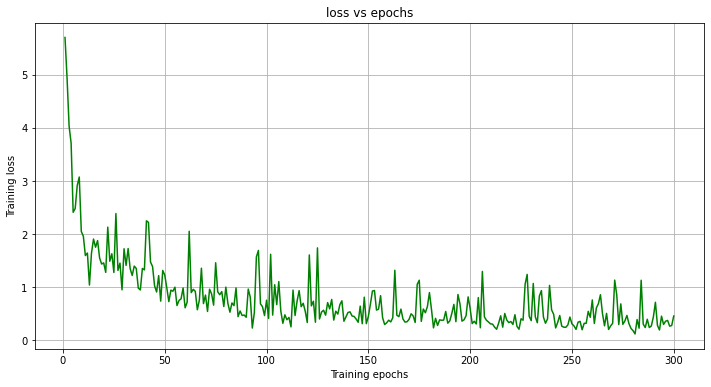

In [26]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(data.epoch, data.loss, color ='g')
plt.xlabel("Training epochs")
plt.ylabel("Training loss")
plt.title("loss vs epochs")
plt.grid(True)
plt.savefig('training_loss.jpg')
plt.show()
#plt.savefig('training_loss.jpg')

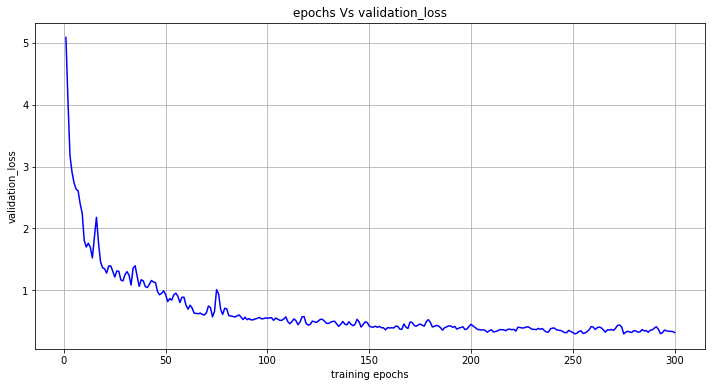

In [27]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(data.epoch, data.val_loss, color = 'blue')
#plt.plot(data.epoch, data.loss, color ='red', label = 'training_loss' )
plt.xlabel("training epochs")
plt.ylabel("validation_loss")
plt.title("epochs Vs validation_loss")
plt.grid(True)
plt.savefig('validation_loss.jpg')
plt.show()
